# Исследование объявлений о продаже квартир

В нашем распоряжении данные сервиса Яндекс Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет. Необходимо научиться определять рыночную стоимость объектов недвижимости. Для этого провести исследовательский анализ данных и установить параметры, влияющие на цену объектов. Это позволит построить автоматизированную систему: она отследит аномалии и мошенническую деятельность. 

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые — получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта и других объектов — эти данные автоматически получены из геосервисов. Количество парков и водоёмов также заполняется без участия пользователя.

### Откроем файл с данными и изучим общую информацию

   total_images  last_price  total_area first_day_exposition  rooms  \
0            20  13000000.0       108.0  2019-03-07T00:00:00      3   
1             7   3350000.0        40.4  2018-12-04T00:00:00      1   
2            10   5196000.0        56.0  2015-08-20T00:00:00      2   
3             0  64900000.0       159.0  2015-07-24T00:00:00      3   
4             2  10000000.0       100.0  2018-06-19T00:00:00      2   

   ceiling_height  floors_total  living_area  floor is_apartment  studio  \
0            2.70          16.0         51.0      8          NaN   False   
1             NaN          11.0         18.6      1          NaN   False   
2             NaN           5.0         34.3      4          NaN   False   
3             NaN          14.0          NaN      9          NaN   False   
4            3.03          14.0         32.0     13          NaN   False   

   open_plan  kitchen_area  balcony    locality_name  airports_nearest  \
0      False          25.0      NaN  Санкт

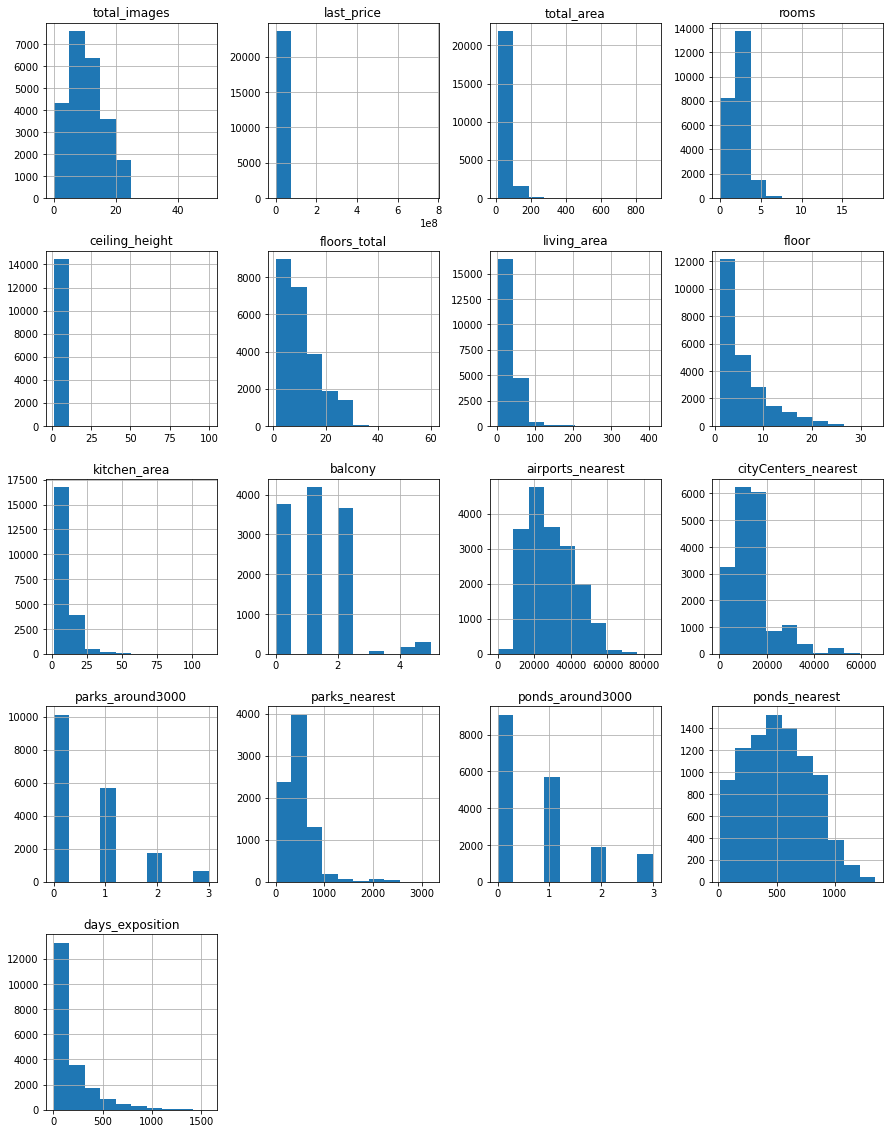

In [1]:
import pandas as pd
data = pd.read_csv('/datasets/real_estate_data.csv', sep='\t') #чтение файла с указанием знака табуляции в качестве разделителя
pd.set_option('display.max_columns', None) #устанавливаем параметры, чтобы отображались все столбцы таблицы
print (data.head()) #вывод первых пяти строк
print (data.info()) #вывод общей информации о DataFrame
print(data.hist(figsize=(15, 20))) #построение гистограмм для всех числовых столбцов таблицы

### Выполним предобработку данных

Первым шагом изучим пропущенные значения в столбцах.
В предыдущем пункте при вызове метода info() видим, что пропущенные значения есть в следующих столбцах (эту же информацию можно получить, выполнив код print (data.isna().sum())):
 - ceiling_height (высота потолков) - предлагается заменить медианным значением;
 - floors_total (всего этажей в доме) - мной было предложено, что данный параметр не заполнен в тех случаях, когда в доме всего один этаж, но предположение было исключено изучением данных (в строках с нулевым значением о количестве этажей присутствуют данные о квартирах, расположенных на разных этажах дома, не только первом), можно было бы предложить заполнить данные номером этажа из столбца floor, но это исказит данные, многие покупатели в фильтрах на сайтах недвижимости выбирают критерий "не последний этаж", соответственно, заполнить пустые данные не представляется возможным;
 - living_area (жилая площадь в квадратных метрах (м²)) - нет возможности заполнить пустые значения, даже разделив объекты по количеству комнат, так как комнаты могут быть разные, может быть большая или, наоборот, совсем небольшая жилая площадь и т.д. (то есть двух- и трехкомнатная квартира вполне могут иметь одинаковую жилую площадь);
 - is_apartment (апартаменты (булев тип)) - нет возможности заполнить пустые значения, тип жилья (апартаменты или нет) определяются при приектировании;
 - kitchen_area (площадь кухни в квадратных метрах (м²)) - нет возможности заполнить пустые значения, аналогично жилой площади;
 - balcony (число балконов) - предполагаем, что если число балконов не указано, следовательно, их в квартире нет (заменяем пустые значения на ноль);
 - locality_name (название населенного пункта) - пустые значения предлагается заменить на "Другие"; 
 - airports_nearest (расстояние до ближайшего аэропорта в метрах (м)) - нет возможности заполнить пустые значения;
 - cityCenters_nearest (расстояние до центра города (м)) - нет возможности заполнить пустые значения;
 - parks_around3000 (число парков в радиусе 3 км) - если данный параметр не указан, можно предположить, что парков в радиусе 3 км нет, заменяем пустые значения на 0;
 - parks_nearest (расстояние до ближайшего парка (м)) - нет возможности заполнить пустые значения;
 - ponds_around3000 (число водоёмов в радиусе 3 км) - если данный параметр не указан, можно предположить, что водоемов в радиусе 3 км нет, заменяем пустые значения на 0;
 - ponds_nearest (расстояние до ближайшего водоёма (м)) - нет возможности заполнить пустые значения;
 - days_exposition (сколько дней было размещено объявление (от публикации до снятия)) - мной былдо предложено, что это квартиры, которые на текущий момент не проданы, было посчитано количество дней до текущей даты (сохранены в новом столбце days_exposition_new, но при построении гистограммы наглядно видно, что все эти значения больше максимального значения столбца 'days_exposition', соответсвенно, предположение было неверным), заполним пропуски медианным значением.

 К пропускам данных могли привести следующие факторы:
 - человеческий фактор (ошибки при вводе данных);
 - ошибки при чтении/копировании/форматировании файла;
 - отсутствие информации в принципе и др.

Дополнительно отметим, что отрицательных (аномальных) значений в столбцах о количестве и номере этажей, площади, цене, количестве балконов и комнат, расстоянии до аэропорта/центра/одоема/парка НЕ зафиксировано (наглядно видно на гистограммамах). 

total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height           9195
floors_total               86
living_area              1903
floor                       0
is_apartment            20924
studio                      0
open_plan                   0
kitchen_area             2278
balcony                 11519
locality_name              49
airports_nearest         5542
cityCenters_nearest      5519
parks_around3000         5518
parks_nearest           15620
ponds_around3000         5518
ponds_nearest           14589
days_exposition          3181
dtype: int64
total_images                0
last_price                  0
total_area                  0
first_day_exposition        0
rooms                       0
ceiling_height              0
floors_total               86
living_area                 0
floor                       0
is_apartment                0
studio                     

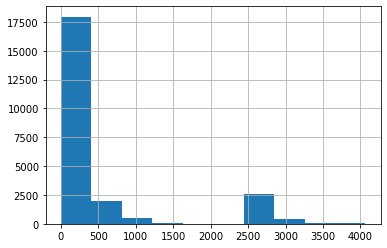

In [2]:
from datetime import datetime, date

print (data.isna().sum()) #находим пустые значения
data['ceiling_height'] = data['ceiling_height'].fillna(data['ceiling_height'].median()) #заменяем пустые значения о высоте потолков на медианное значение
data['balcony'] = data['balcony'].fillna('0') #заменяем пустые значения о количестве балконов на "0"
data['locality_name'] = data['locality_name'].fillna('Другие') #заменяем пустые значения о населенном пункте на значение "Другие"
data['parks_around3000'] = data['parks_around3000'].fillna('0') #заменяем пустые значения о количестве парков в радиусе 3 км на "0"
data['ponds_around3000'] = data['ponds_around3000'].fillna('0') #заменяем пустые значения о количестве водоемов в радиусе 3 км на "0"

# создаем столбец 'days_exposition_new' с данными о количестве дней с даты публикации
data['first_day_exposition']=pd.to_datetime(data['first_day_exposition'])
def days_exposition_today(data):
    date_today = date.today()
    first_day_exposition = datetime.date(data['first_day_exposition']) 
    days_exposition_new = date_today - first_day_exposition
    return days_exposition_new.days
data['days_exposition_new']= data['days_exposition'].fillna(value=data.apply(days_exposition_today, axis=1)) 
pd.Series(data['days_exposition_new']).hist()

data['days_exposition'] = data['days_exposition'].fillna(data['days_exposition'].median()) #заменяем пустые значения о количестве дней размещения объявления на медианное значение

#заполняем пустые значения в столбце living_area медианой по количеству комнат
for room in data['rooms'].unique():
    data.loc[(data['rooms'] == room) & (data['living_area'].isna()), 'living_area'] = \
    data.loc[(data['rooms'] == room), 'living_area'].median()

data['is_apartment'] = data['is_apartment'].fillna('False') #заменяем пустые значения об апартаментах на "False"
    
print (data.isna().sum()) #находим пустые значения для проверки


Далее рассмотрим типы данных в каждом столбце.
Требуется заменить тип данных в следующих слобцах:
 - first_day_exposition - на datetime, так как это дата публикации объявления (было выполнено ранее при работе с пустыми данными)
 - is_apartment - на bool (в соответствии с постановкой задачи и принимаемыми значениями)
 - balcony - на целое значение (int), так как количество балконом может быть только целым числом

In [3]:
data['is_apartment'] = data['is_apartment'].astype(bool)
data['balcony'] = data['balcony'].astype(int)

print (data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 23 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23699 non-null  int64         
 1   last_price            23699 non-null  float64       
 2   total_area            23699 non-null  float64       
 3   first_day_exposition  23699 non-null  datetime64[ns]
 4   rooms                 23699 non-null  int64         
 5   ceiling_height        23699 non-null  float64       
 6   floors_total          23613 non-null  float64       
 7   living_area           23699 non-null  float64       
 8   floor                 23699 non-null  int64         
 9   is_apartment          23699 non-null  bool          
 10  studio                23699 non-null  bool          
 11  open_plan             23699 non-null  bool          
 12  kitchen_area          21421 non-null  float64       
 13  balcony         

Изучим уникальные значения в столбце с названиями населенных пунктов и устраним неявные дубликаты.
Заменим "ё" на "е", а также уберем тип населенного пункта (потому что, наприме, Мурино записано, как минимум, в трех вариантах - поселок Мурино, посёлок Мурино и Мурино).
Сохраним новые значения в новый столбец на тот случай, если в последующем тип населенного пункта потребуется для анализа данных.

In [4]:
data['locality_name_new'] = (
    data['locality_name']
    .str.replace('ё', 'е')
    .replace(['поселок ', 'село ', 'городского ', 'типа ', 'деревня ', 'городской ', 'садовое ', 'товарищество ', 'коттеджный ', 'станции ', 'садоводческое ', 'некоммерческое ', 'при железнодорожной '], '', regex=True)
) 
data['locality_name_new'].unique()

array(['Санкт-Петербург', 'Шушары', 'Янино-1', 'Парголово', 'Мурино',
       'Ломоносов', 'Сертолово', 'Петергоф', 'Пушкин', 'Кудрово',
       'Коммунар', 'Колпино', 'Красный Бор', 'Гатчина', 'Федоровское',
       'Выборг', 'Кронштадт', 'Кировск', 'Новое Девяткино',
       'Металлострой', 'Лебяжье', 'Сиверский', 'Молодцово',
       'Кузьмоловский', 'Новая Ропша', 'Павловск', 'Пикколово',
       'Всеволожск', 'Волхов', 'Кингисепп', 'Приозерск', 'Сестрорецк',
       'Куттузи', 'Аннино', 'Ефимовский', 'Плодовое', 'Заклинье',
       'Торковичи', 'Первомайское', 'Красное Село', 'Понтонный',
       'Сясьстрой', 'Старая', 'Лесколово', 'Новый Свет', 'Сланцы',
       'Путилово', 'Ивангород', 'Шлиссельбург', 'Никольское',
       'Зеленогорск', 'Сосновый Бор', 'Оржицы', 'Кальтино', 'Романовка',
       'Бугры', 'Рощино', 'Кириши', 'Луга', 'Волосово', 'Отрадное',
       'Павлово', 'Оредеж', 'Копорье', 'Молодежное', 'Тихвин', 'Победа',
       'Нурма', 'Синявино', 'Тосно', 'Стрельна', 'Бокситогорск',

Добавим проверку на явные дубликаты (результат выполнения строки ниже указывает, что их нет).

In [5]:
data.duplicated().sum()

0

Переименование столбцов. </b> Для полноты предобработки данных исправим следующие названия столбцов:
    
    - cityCenters_nearest - заменим на city_сenters_nearest;
    - parks_around3000 - заменим на parks_around_3000;
    - ponds_around3000 - заменим на ponds_around_3000.


In [6]:
data = data.rename(columns={'cityCenters_nearest':'city_сenters_nearest', 'parks_around3000':'parks_around_3000', 'ponds_around3000':'ponds_around_3000'})
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23699 entries, 0 to 23698
Data columns (total 24 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   total_images          23699 non-null  int64         
 1   last_price            23699 non-null  float64       
 2   total_area            23699 non-null  float64       
 3   first_day_exposition  23699 non-null  datetime64[ns]
 4   rooms                 23699 non-null  int64         
 5   ceiling_height        23699 non-null  float64       
 6   floors_total          23613 non-null  float64       
 7   living_area           23699 non-null  float64       
 8   floor                 23699 non-null  int64         
 9   is_apartment          23699 non-null  bool          
 10  studio                23699 non-null  bool          
 11  open_plan             23699 non-null  bool          
 12  kitchen_area          21421 non-null  float64       
 13  balcony         

### Добавим в таблицу новые столбцы

In [7]:
data['price_meter'] = round(data['last_price']/data['total_area'], 2) #цена одного квадратного метра (нужно поделить стоимость объекта на его общую площадь, а затем округлить до двух знаков после запятой);
data ['day_of_the_week_exposition'] = data['first_day_exposition'].dt.weekday #день недели публикации объявления (0 — понедельник, 1 — вторник и так далее);
data ['month_exposition'] = data['first_day_exposition'].dt.month #месяц публикации объявления;
data ['year_exposition'] = data['first_day_exposition'].dt.year #год публикации объявления;

#тип этажа квартиры (значения — «первый», «последний», «другой»);
def floor_type(data):
    floor = data['floor']
    floors_total = data['floors_total']
    if floor == 1:
        return 'первый'
    elif floor == floors_total:
        return 'последний'
    return 'другой'
data['floor_type']=data.apply(floor_type, axis=1)

data['city_centers_nearest_km'] = round(data['city_сenters_nearest']/1000) #расстояние до центра города в километрах (переведите из м в км и округлите до ближайших целых значений).
data

,total_images,last_price,total_area,first_day_exposition,rooms,ceiling_height,floors_total,living_area,floor,is_apartment,studio,open_plan,kitchen_area,balcony,locality_name,airports_nearest,city_сenters_nearest,parks_around_3000,parks_nearest,ponds_around_3000,ponds_nearest,days_exposition,days_exposition_new,locality_name_new,price_meter,day_of_the_week_exposition,month_exposition,year_exposition,floor_type,city_centers_nearest_km
0,20,13000000.0,108.00,2019-03-07,3,2.70,16.0,51.0,8,True,False,False,25.00,0,Санкт-Петербург,18863.0,16028.0,1.0,482.0,2.0,755.0,95.0,2505.0,Санкт-Петербург,120370.37,3,3,2019,другой,16.0
1,7,3350000.0,40.40,2018-12-04,1,2.65,11.0,18.6,1,True,False,False,11.00,2,посёлок Шушары,12817.0,18603.0,0.0,NaN,0.0,NaN,81.0,81.0,Шушары,82920.79,1,12,2018,первый,19.0
2,10,5196000.0,56.00,2015-08-20,2,2.65,5.0,34.3,4,True,False,False,8.30,0,Санкт-Петербург,21741.0,13933.0,1.0,90.0,2.0,574.0,558.0,558.0,Санкт-Петербург,92785.71,3,8,2015,другой,14.0
3,0,64900000.0,159.00,2015-07-24,3,2.65,14.0,45.0,9,True,False,False,NaN,0,Санкт-Петербург,28098.0,6800.0,2.0,84.0,3.0,234.0,424.0,424.0,Санкт-Петербург,408176.10,4,7,2015,другой,7.0
4,2,10000000.0,100.00,2018-06-19,2,3.03,14.0,32.0,13,True,False,False,41.00,0,Санкт-Петербург,31856.0,8098.0,2.0,112.0,1.0,48.0,121.0,121.0,Санкт-Петербург,100000.00,1,6,2018,другой,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23694,9,9700000.0,133.81,2017-03-21,3,3.70,5.0,73.3,3,True,False,False,13.83,0,Санкт-Петербург,24665.0,4232.0,1.0,796.0,3.0,381.0,95.0,3221.0,Санкт-Петербург,72490.85,1,3,2017,другой,4.0
23695,14,3100000.0,59.00,2018-01-15,3,2.65,5.0,38.0,4,True,False,False,8.50,0,Тосно,NaN,NaN,0,NaN,0,NaN,45.0,45.0,Тосно,52542.37,0,1,2018,другой,NaN
23696,18,2500000.0,56.70,2018-02-11,2,2.65,3.0,29.7,1,True,False,False,NaN,0,село Рождествено,NaN,NaN,0,NaN,0,NaN,95.0,2894.0,Рождествено,44091.71,6,2,2018,первый,NaN
23697,13,11475000.0,76.75,2017-03-28,2,3.00,17.0,30.5,12,True,False,False,23.30,2,Санкт-Петербург,39140.0,10364.0,2.0,173.0,3.0,196.0,602.0,602.0,Санкт-Петербург,149511.40,1,3,2017,другой,10.0


### Проведём исследовательский анализ данных

4.1 Изучим ряд параметров, построив отдельные гистограммы для каждого из этих параметров.
Выведем для удобства числовое описание диаграммы размаха, чтобы корректно указывать параметры при построении гистограмм.

In [8]:
import matplotlib.pyplot as plt
data.describe()

,total_images,last_price,total_area,rooms,ceiling_height,floors_total,living_area,floor,kitchen_area,balcony,airports_nearest,city_сenters_nearest,parks_nearest,ponds_nearest,days_exposition,days_exposition_new,price_meter,day_of_the_week_exposition,month_exposition,year_exposition,city_centers_nearest_km
count,23699.000000,2.369900e+04,23699.000000,23699.000000,23699.000000,23613.000000,23699.000000,23699.000000,21421.000000,23699.000000,18157.000000,18180.000000,8079.000000,9110.000000,23699.000000,23699.000000,2.369900e+04,23699.000000,23699.000000,23699.000000,18180.000000
mean,9.858475,6.541549e+06,60.348651,2.070636,2.724358,10.673824,34.321982,5.892358,10.569807,0.591080,28793.672193,14191.277833,490.804555,517.980900,169.360226,514.404701,9.942166e+04,2.569307,6.400101,2017.367146,14.184818
std,5.682529,1.088701e+07,35.654083,1.078405,0.988298,6.597173,21.700627,4.885249,5.905438,0.959298,12630.880622,8608.386210,342.317995,277.720643,206.535633,878.528202,5.030680e+04,1.789082,3.491561,1.039771,8.616194
min,0.000000,1.219000e+04,12.000000,0.000000,1.000000,1.000000,2.000000,1.000000,1.300000,0.000000,0.000000,181.000000,1.000000,13.000000,1.000000,1.000000,1.118300e+02,0.000000,1.000000,2014.000000,0.000000
25%,6.000000,3.400000e+06,40.000000,1.000000,2.600000,5.000000,18.400000,2.000000,7.000000,0.000000,18585.000000,9238.000000,288.000000,294.000000,45.000000,45.000000,7.658547e+04,1.000000,3.000000,2017.000000,9.000000
50%,9.000000,4.650000e+06,52.000000,2.000000,2.650000,9.000000,30.300000,4.000000,9.100000,0.000000,26726.000000,13098.500000,455.000000,502.000000,95.000000,124.000000,9.500000e+04,3.000000,6.000000,2017.000000,13.000000
75%,14.000000,6.800000e+06,69.900000,3.000000,2.700000,16.000000,42.700000,8.000000,12.000000,1.000000,37273.000000,16293.000000,612.000000,729.000000,199.000000,390.000000,1.142563e+05,4.000000,10.000000,2018.000000,16.000000
max,50.000000,7.630000e+08,900.000000,19.000000,100.000000,60.000000,409.700000,33.000000,112.000000,5.000000,84869.000000,65968.000000,3190.000000,1344.000000,1580.000000,4066.000000,1.907500e+06,6.000000,12.000000,2019.000000,66.000000


Общая площадь (total_area).
Из гистограммы ниже видно, что наиболее популярны в списке продаж квартиры с площадью до 200 кв.м.
Из диаграммы размаха видим, что максимальное значение данного параметра = 900 кв.м.
Казалось бы, похоже на опечатку, но в этой строке указано 12 комнат, вполне возможна продажа какого-то особняка. Удалим строки, где площадь более 400 кв.м. (как редкие - всего 23 строки из 23699, это около 0,1 %).

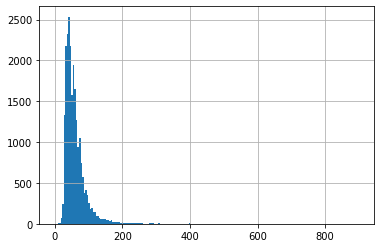

In [9]:
import matplotlib.pyplot as plt
pd.Series(data['total_area']).hist(bins=200, range=(0,900))
data = data.query('total_area <= 400')

Жилая площадь (living_area).
Выводы аналогичны выводам об общей площади недвижимости.
Из гистограммы ниже видно, что наиболее популярны в списке продаж квартиры с площадью до 200 кв.м.
Из диаграммы размаха видим, что максимальное значение данного параметра = 409,7 кв.м.
Казалось бы, похоже на опечатку, но при в этой строке указано 12 и 15 комнат, вполне возможна продажа каких-то особняков. Удалим строки, где жилая площадь более 200 кв.м. (как редкие - всего 31 строка из 23699, это около 0,1 %).

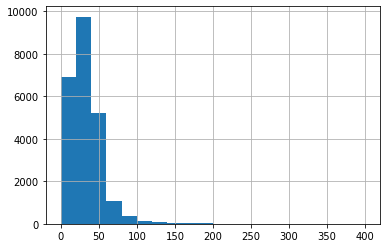

In [10]:
pd.Series(data['living_area']).hist(bins=20, range=(0,400))
data = data.query('living_area <= 200')

Площадь кухни (kitchen_area).
Выводы аналогичны выводам об общей площади недвижимости.
Из гистограммы ниже видно, что наиболее популярны в списке продаж квартиры с площадью кухни до 60 кв.м.
Из диаграммы размаха видим, что максимальное значение данного параметра = 112 кв.м.
Это все те же особняки из предыдущих двух примеров. Удалим строки, где площадь кухни более 60 кв.м. (как редкие - всего 24 строки из 23699, это около 0,1 %).

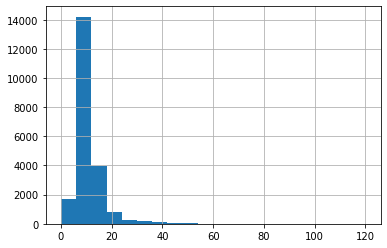

In [11]:
pd.Series(data['kitchen_area']).hist(bins=20, range=(0,120))
data = data.query('kitchen_area <= 60')

Цена объекта (last_price).
Максимальное значение (763000000) сильно "выбивается" из общей картины, при этом стоимость одного квадратного метра также завышена в разы (что подтверждает возможную ошибку при вводе данных). Удалим эту строку.

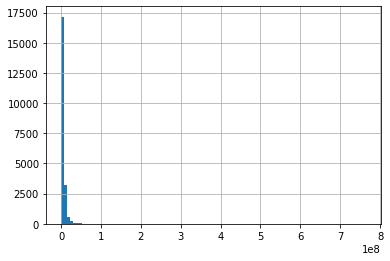

In [12]:
pd.Series(data['last_price']).hist(bins=100, range=(0,763000000))
data = data.query('last_price < 763000000')

Количество комнат (rooms).
Из диаграммы размаха видим, что максимальное значение данного параметра = 19 комнат.
Удалим строки, где комнат более 10 (как редкие - всего 8 строк из 23699).

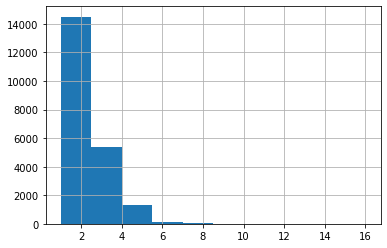

In [13]:
pd.Series(data['rooms']).hist()
data = data.query('rooms <= 10')

Высота потолков (ceiling_height).
Изучив данные, логично предположить, что на самом деле значения от 22 до 32 метров - это вещественные значения от 2.2 м до 3.2 м. Заменим эти значения, а потом удалим значения больше 5 (как аномальные и редкие).

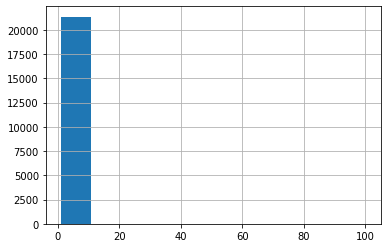

In [14]:
pd.Series(data['ceiling_height']).hist()   
        
#заменяем значения от 22 до 32 метров на значения от 2.2 м до 3.2 м. 
def ceiling_height(data):
    ceiling_height = data['ceiling_height']
    if 22<=ceiling_height<=32:
        ceiling_height = ceiling_height/10
    return ceiling_height
data['ceiling_height']=data.apply(ceiling_height, axis=1)

data = data.query('ceiling_height <= 5') #удаляем строки со значением более 5 метров

Тип этажа квартиры («первый», «последний», «другой») (floor_type).
Данный столбец заполнен при анализе данных, аномальных значений нет, что подтверждается гистограммой ниже.

<AxesSubplot:>

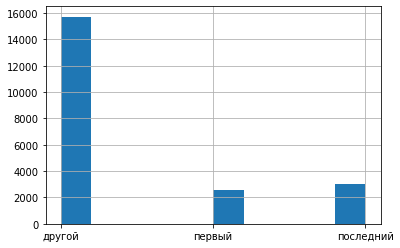

In [15]:
pd.Series(data['floor_type']).hist()

Общее количество этажей в доме (floors_total).
В таблице всего два значения более 40, удалим их, как редкие.

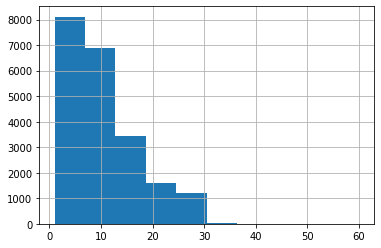

In [16]:
pd.Series(data['floors_total']).hist()
data = data.query('floors_total <= 40')

Расстояние до центра города в метрах (cityCenters_nearest) и расстояние до ближайшего парка (parks_nearest).
В целом, данные кажутся "адекватными", предлагается оставить их без изменений.
Как сказано в условии, эти данные автоматически получены из геосервисов. Вероятно, именно поэтому они не требуют предобработки. Но не стоит забывать, что в этих данных есть пустые значения.

<AxesSubplot:>

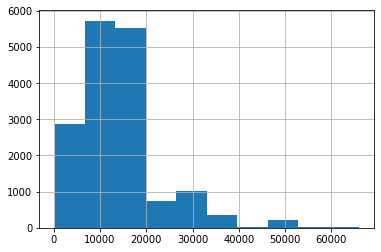

In [17]:
pd.Series(data['city_сenters_nearest']).hist()

<AxesSubplot:>

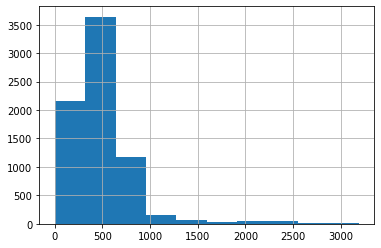

In [18]:
pd.Series(data['parks_nearest']).hist()

4.2 Изучим, как быстро продавались квартиры (столбец `days_exposition`).
Построим гистограмму, выведем числовое описание диаграммы размаха и рассчитаем среднее и медиану.
Нормальные значение диаграммы размаха размещены в пределах от 1 (минимальное значение, так как "левый ус" диагараммы размаха длиннее min (Q1-1,5*IQR = 48-1,5*208 = -264)) до 517 (Q3+1,5*IQR = 205-1,5*208 = 517).
Из полученных данных видим, что обычно продажа квартир занимает от 48 до 205 дней, в среднем 95 дней.
Быстрыми можно считать продажи менее 48 дней, при этом продажи более 517 дней можно считать необычно долгими (значения выходят за границы нормальных значений диаграммы размаха). 

Среднее значение количества дней продажи квартиры равно: 172.69330017828656
Медианное значение количества дней продажи квартиры равно: 95.0

Описание диаграммы размаха:
count    21314.000000
mean       172.693300
std        208.350079
min          1.000000
25%         48.000000
50%         95.000000
75%        204.000000
max       1580.000000
Name: days_exposition, dtype: float64


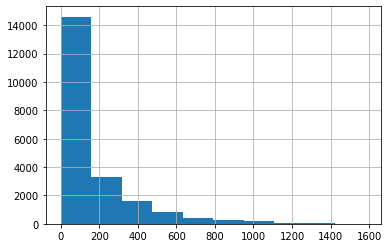

In [19]:
pd.Series(data['days_exposition']).hist(bins=10)
print ('Среднее значение количества дней продажи квартиры равно:', data['days_exposition'].mean())
print ('Медианное значение количества дней продажи квартиры равно:', data['days_exposition'].median())
print()
print('Описание диаграммы размаха:')
print(data['days_exposition'].describe())

4.3 Определим факторы, которые больше всего влияют на общую (полную) стоимость объекта. 
Построим графики, которые показывают зависимость цены от параметров:

        - общая площадь - из графика видим, что есть прямая зависимость (чем больше общая площадь, тем выше цена);
        - жилая площадь - из графика видим, что есть прямая зависимость (чем больше жилая площадь, тем выше цена);
        - площадь кухни - из графика видим, что есть прямая зависимость (чем больше площадь кухни, тем выше цена);
        - количество комнат - явной зависимости цены от количества комнат из графика не видим (комнаты могут быть различными по площади);
        - тип этажа, на котором расположена квартира (первый, последний, другой) - из графика видим, что квартиры на первом и последнем этажах ценятся меньше, чем на других этажах, при этом квартиры на первом этаже имеют цену ниже, чем квартиры на последних этажах;
        - дата размещения:
            - день недели - стоимость объекта (если "верить" графику) выше у объявлений, размещенных во вторник и среду, и самая низкая у объявлений, размещенных в воскресенье, 
            - месяц - стоимость объекта выше у объявлений, размещенных в декабре, и самая низкая у объявлений, размещенных в июне,
            - год - цены мна недвижимость в 2014 году были выше,чемв другие года, далее наблюдается спад до 2017 года, после чего уровень цен снова растет.


<AxesSubplot:xlabel='year_exposition'>

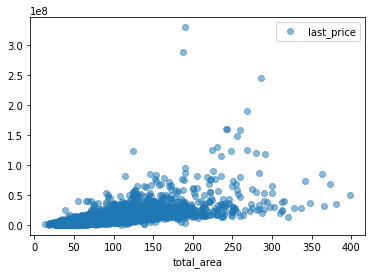

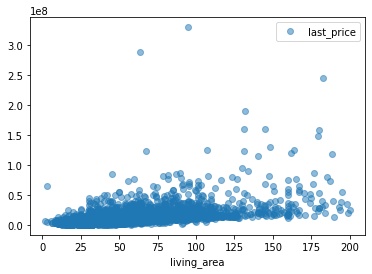

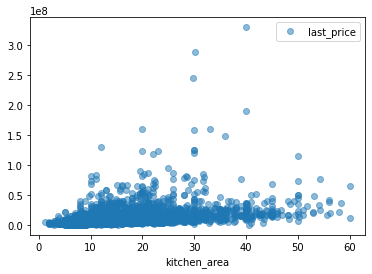

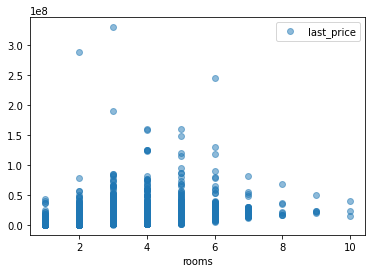

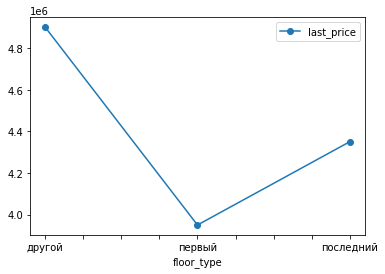

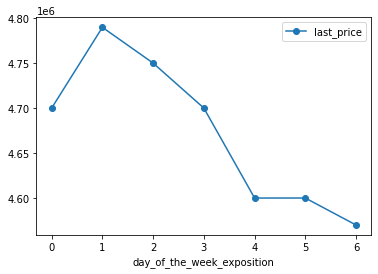

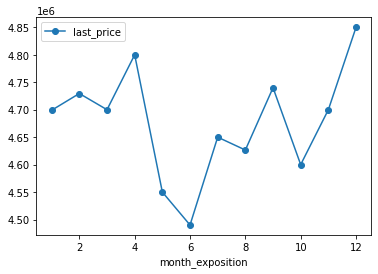

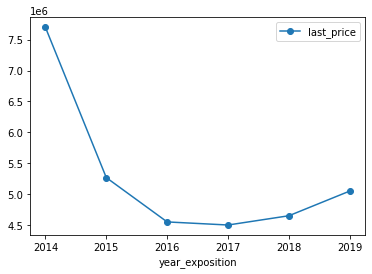

In [20]:
data.plot(x='total_area', y='last_price', style='o', alpha=0.5) #график зависимости цены от общей площади
data.plot(x='living_area', y='last_price', style='o', alpha=0.5) #график зависимости цены от жилой площади
data.plot(x='kitchen_area', y='last_price', style='o', alpha=0.5) #график зависимости цены от площади кухни
data.plot(x='rooms', y='last_price', style='o', alpha=0.5) #график зависимости цены от количества комнат
data.pivot_table(index='floor_type', values='last_price', aggfunc='median').plot(style='o-') #график зависимости цены от типа этажа
data.pivot_table(index='day_of_the_week_exposition', values='last_price', aggfunc='median').plot(style='o-') #график зависимости цены от дня недели размещения
data.pivot_table(index='month_exposition', values='last_price', aggfunc='median').plot(style='o-') #график зависимости цены от месяца размещения
data.pivot_table(index='year_exposition', values='last_price', aggfunc='median').plot(style='o-') #график зависимости цены от года размещения


4.4 Посчитаем среднюю цену одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений.
Из квартир, входящих в ТОП-10 по количеству продаваемых объектов самые дорогих в Санкт-Петербурге, а самая низкая цена в Выборге.

In [21]:
data_top10 = data.groupby('locality_name_new')['last_price'].agg(['count', 'median']).sort_values(by='count', ascending=False).head(10)
data_top10

,count,median
locality_name_new,,
Санкт-Петербург,14246,5517500.0
Мурино,480,3585000.0
Шушары,397,3990000.0
Кудрово,387,4000000.0
Всеволожск,357,3450000.0
Пушкин,334,5187319.0
Колпино,322,3600000.0
Гатчина,294,3100000.0
Парголово,289,4130000.0


4.5 Выделим квартиры в Санкт-Петербурге и вычислим их среднюю стоимость на разном удалении от центра.
Из графика видно, что квартиры дороже ближе к центру, однако у графика есть рост при значении стоимости квартиры около 27 км от центра.
Могу выявить две причины такого расхождения:
- найдены и исключены не все "аномальные" значения данных;
- вероятно, на расстоянии 27 км расположен какой-то элитный район, в котором цены выше

На мой взгляд, логичнее сравнивать не стоимость квартиры, а стоимость квадратного метра, поэтому также построен график изменения средней цены КВАДРАТНОГО МЕТРА для каждого километра от центра Петербурга. Но на нем также наблюдается скачок в районе 27 км от центра.

                         last_price
city_centers_nearest_km            
0.0                      15900000.0
1.0                      11495000.0
2.0                      10400000.0
3.0                       8400000.0
4.0                       9125000.0
5.0                       9286382.5
6.0                       8600000.0
7.0                       7650000.0
8.0                       7500000.0
9.0                       5445000.0
10.0                      5050000.0
11.0                      5000000.0
12.0                      5000000.0
13.0                      5200000.0
14.0                      4900000.0
15.0                      4900000.0
16.0                      4800000.0
17.0                      4600000.0
18.0                      4355000.0
19.0                      4500000.0
20.0                      5800000.0
21.0                      5244738.0
22.0                      4900000.0
23.0                      4590000.0
24.0                      3670000.0
25.0                      42

<AxesSubplot:xlabel='city_centers_nearest_km'>

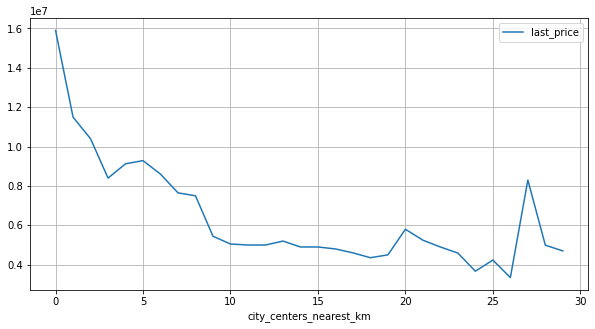

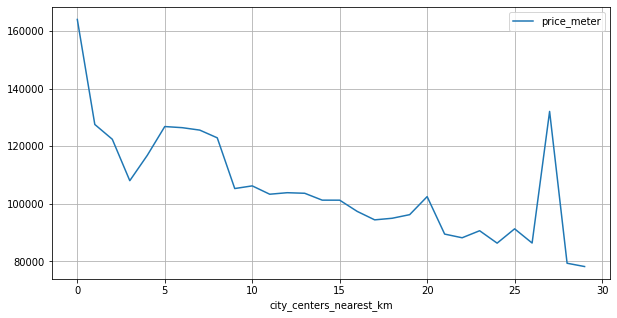

In [22]:
print ((
    data.query('locality_name_new == "Санкт-Петербург"')
    .pivot_table(index='city_centers_nearest_km', values='last_price', aggfunc='median')
))

print(
(
    data.query('locality_name_new == "Санкт-Петербург"')
    .pivot_table(index='city_centers_nearest_km', values='last_price', aggfunc='median')
    .plot(grid=True, figsize=(10, 5))
))

(
    data.query('locality_name_new == "Санкт-Петербург"')
    .pivot_table(index='city_centers_nearest_km', values='price_meter', aggfunc='median')
    .plot(grid=True, figsize=(10, 5))
)

### Общий вывод

При выполнении проекта были изучены исходные данные от сервиса Яндекс Недвижимость — архив объявлений о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет, проведен исследовательский анализ данных и установлены параметры, влияющие на цену объектов. 
    
На первоначальном этапе была выполнена предобработка данных:
1. Найдены, изучены и, по возможности, заполнены пустые значения в таких столбцах, как:
            - высота потолков - пустые значения заменены медианным значением;
            - число балконов - предполагаем, что если число балконов не указано, следовательно, их в квартире нет (заменяем пустые значения на ноль);
            - название населенного пункта - пустые значения заменены на "Другие";
            - число парков в радиусе 3 км - если данный параметр не указан, можно предположить, что парков в радиусе 3 км нет;
            - число водоёмов в радиусе 3 км - если данный параметр не указан, можно предположить, что водоемов в радиусе 3 км нет;
            - жилая площадь в квадратных метрах (м²) - заменили медианой (сгруппировав значения по количеству комнат);
            - апартаменты (булев тип) - предположим, что если не указано, что этот объект недвижимости является апартаментами, то он таковым не является, заменим путые значения на "False".
    
2. Исключены дубликаты в названии населенных пунктов;
3. Исправлены типы данных и названия столбцов.
    
В рамках исследовательского анализа данных были добавлены новые столбцы со сводной информацией об объектах недвижимости, построены отдельные гистограммы для каждого из заданного ряда параметров, исключены (заменой или удалением) редкие и выбивающиеся значения. 
    
Было изучено, как быстро продавались квартиры.
    Из полученных данных видим, что обычно продажа квартир занимает от 48 до 205 дней, в среднем 95 дней. Быстрыми можно считать продажи менее 48 дней, при этом продажи более 517 дней можно считать необычно долгими (значения выходят за границы нормальных значений диаграммы размаха).
    
Были определены факторы, которые больше всего влияют на общую (полную) стоимость объекта:
     - общая и жилая площадь, площадь кухни - из графиков видим, что есть прямая зависимость (чем больше общая и/или жилая площадь, а также площадь кухни, тем выше цена);
     - тип этажа, на котором расположена квартира (первый, последний, другой) - из графика видим, что квартиры на первом и последнем этажах ценятся меньше, чем на других этажах, при этом квартиры на первом этаже имеют цену ниже, чем квартиры на последних этажах;
     - дата размещения:
            - день недели - стоимость объекта (если "верить" графику) выше у объявлений, размещенных во вторник и среду, и самая низкая у объявлений, размещенных в воскресенье, 
            - месяц - стоимость объекта выше у объявлений, размещенных в декабре, и самая низкая у объявлений, размещенных в июне,
            - год - цены на недвижимость в 2014 году были выше,чемв другие года, далее наблюдается спад до 2017 года, после чего уровень цен снова растет.
    
Посчитана средняя цена одного квадратного метра в 10 населённых пунктах с наибольшим числом объявлений. Из квартир, входящих в ТОП-10 по количеству продаваемых объектов, самые дорогих в Санкт-Петербурге, а самая низкая цена в Выборге.
    
Выделим квартиры в Санкт-Петербурге и вычислена их средняя стоимость на разном удалении от центра. Квартиры дороже ближе к центру, однако у графика есть рост при значении стоимости квартиры около 27 км от центра. Могу выявить две причины такого расхождения:
 - найдены и исключены не все "аномальные" значения данных;
 - вероятно, на расстоянии 27 км расположен какой-то элитный район, в котором цены выше
    

